# DECODE - Fit SMLM Data
The purpose of this notebook is to demonstrate the fitting procedure for a pretrained model.
Please be advised to have a read of the Introduction notebook first.

In [3]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

## Set parameters
Set device for inference (i.e. CUDA vs. CPU, for our setup inference on the CPU is about 10 times slower)

In [4]:
device = 'cuda'  # or 'cpu'

## Specify paths for the model, parameters and frames
If you trained you own model (using the Training notebook) you can specify it's path here. 

**Important** If the camera parameters of the training differ from the data which should be fitted (e.g. different EM gain), you can try to use the model anyways, but you must specify them here since we convert to photon units before forwarding through the model.

In [5]:
param_path = 'config/notebook_example.yaml'
model_path = '2020-10-07_14-11-51_turagas-ws4/model_0.pt'
frame_path = 'package_1/frames.tif'

# specify camera parameters of tiffs
meta = {
    'Camera': {
        'baseline': 398.6,
        'e_per_adu': 5.0,
        'em_gain': 50.0,
        'spur_noise': 0.0015  # if you don't know, you can set this to 0.
    }
}

Alternatively if you just want to check out the fitting procedure we provide several example data for trying out DECODE. For this we load a gateway file which includes the links to the respective data.

In [6]:
gateway = decode.utils.example_helper.load_gateway()

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
package = gateway['examples']['package_1']

# get paths to files
zip_folder = decode.utils.example_helper.load_example_package(
    path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'], mode='fit')

frame_path = zip_folder / 'frames.tif'
meta_path = zip_folder / 'meta.yaml'
model_path = zip_folder / 'model.pt'
param_path = zip_folder / 'param_run.yaml'

# load meta information (em gain of tif etc.)
with meta_path.open('r') as f:
    meta = yaml.safe_load(f)

Found file already in Cache.


## Load Parameters and Model
Specify Post-Processing as by the parameter file you trained the model with

In [7]:
param = decode.utils.param_io.load_params(param_path)
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                              input_file=model_path,
                                              output_file=None).load_init()

Model instantiated.
Model SHA-1 hash: 6461ac11caee1eaf731c65f280eecec8061d2c31
Loaded pretrained model: package_1/model.pt


In [8]:
# overwrite camera
param = decode.utils.param_io.autofill_dict(meta['Camera'], param.to_dict(), mode_missing='include')
param = decode.utils.param_io.RecursiveNamespace(**param)

## Load and Process Frames
Load TIFF file.
Change only needed if you load a custom tif file.
Note that the TIFF loader will auto-load and concatenate tiff files
that are consecutive and share
the same meta data. For example specifying `dummy.tif` will also load  `dummy_0.tif, dummy_1.tif` if present in the
same folder.
If you have single page tiff files, you can also specify a folder.

In [9]:
# depends on your input, e.g. load a tiff
frames = decode.utils.frames_io.load_tif(frame_path)

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.device = 'cpu'

## Set Up Pre- and Post-Processing

In [10]:
# setup frame processing as by the parameter with which the model was trained
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.frame_processing.Mirror2D(dims=-1),
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

# determine extent of frame and its dimension after frame_processing
size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.size(), frame_proc.forward)  # frame size after processing
frame_extent = ((-0.5, size_procced[-2] - 0.5), (-0.5, size_procced[-1] - 0.5))


# Setup post-processing
# It's a sequence of backscaling, relative to abs. coord conversion and frame2emitter conversion
post_proc = decode.neuralfitter.utils.processing.TransformSequence([
    
    decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),
    
    decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                          yextent=frame_extent[1],
                                                          img_shape=size_procced[-2:]),
    
    decode.neuralfitter.post_processing.NMSPostProcessing(raw_th=0.1,
                                                          xy_unit='px', 
                                                          px_size=param.Camera.px_size)
    
    
])

## Fit the Data

In [11]:
infer = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
                                  frame_proc=frame_proc, post_proc=post_proc,
                                  device=device)

emitter = infer.forward(frames)

  0%|          | 0/313 [00:00<?, ?it/s]/home/lucas/RemoteDeploy/DeepSMLM/decode/neuralfitter/post_processing.py:174: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  batch_ix = active_px.nonzero()[:, 0]
100%|██████████| 313/313 [01:23<00:00,  3.73it/s]


In [12]:
# check on the output
print(emitter)

EmitterSet
::num emitters: 3738801
::xy unit: px
::px size: tensor([127., 117.])
::frame range: 0 - 19999
::spanned volume: [-6.4390653e-01 -6.1614275e-01 -8.0200842e+02] - [175.62737 175.62692 808.56934]


You can check if the predictions look reasonable on a random frame

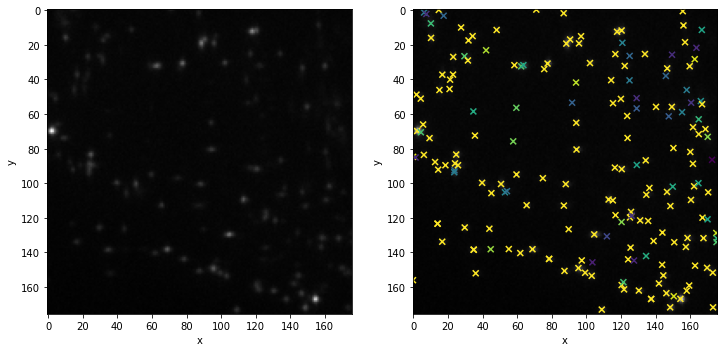

In [13]:
random_ix = torch.randint(frames.size(0), size=(1, )).item()

em_subset = emitter.get_subset_frame(random_ix, random_ix)

plt.figure(figsize=(12, 6))
plt.subplot(121)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]])).plot()
plt.subplot(122)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]]), 
                           pos_out=em_subset.xyz_px, phot_out=em_subset.prob).plot()
plt.show()

We provide a simple histogram rendering procedure for initial evaluation. You can specify the pixel size in nm, the sigma value for a Gaussian blur, an a clipping value for the brightness to control the color range.

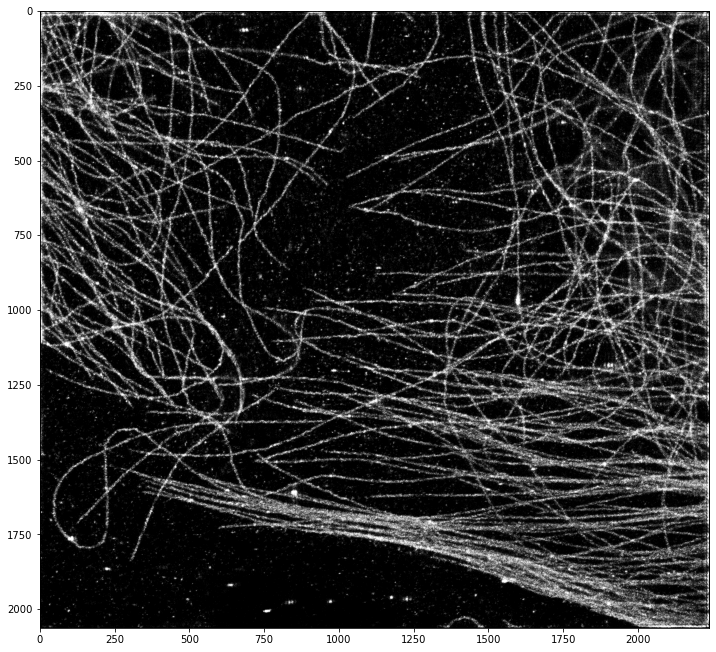

In [14]:
plt.figure(figsize=(12, 12))
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., clip_percentile=97.).render(emitter)

plt.show()

## Postprocessing

DECODE will in general detect very high numbers of emitters, including those with high uncertainties.  
Fortunately every DECODE prediction includes uncertainty estimates in x,y and z which we plot here.

Text(0.5, 0, 'Sigma Estimate in Z (nm)')

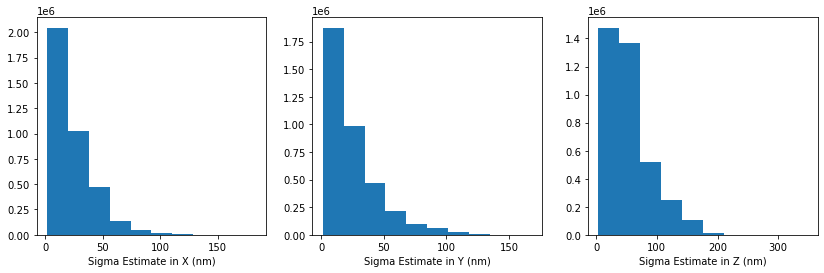

In [15]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.hist(emitter.xyz_sig_nm[:, 0].numpy())
plt.xlabel('Sigma Estimate in X (nm)')

plt.subplot(132)
plt.hist(emitter.xyz_sig_nm[:, 1].numpy())
plt.xlabel('Sigma Estimate in Y (nm)')

plt.subplot(133)
plt.hist(emitter.xyz_sig_nm[:, 2].numpy())
plt.xlabel('Sigma Estimate in Z (nm)')

It is almost always beneficial for the image quality to remove the worst localizations. 
Below we remove all localizations with uncertainties that exceed 40 nm in x,y or 80 nm in z.
This leaves us with 74% of the detections. Alternatively you can specify the remaining percentage directly with the `emitter.filter_by_sigma(fraction)` method.
If you compare the rendering to the previous (unfiltered) one, you can see that this procedure eliminated all visible artefacts.  

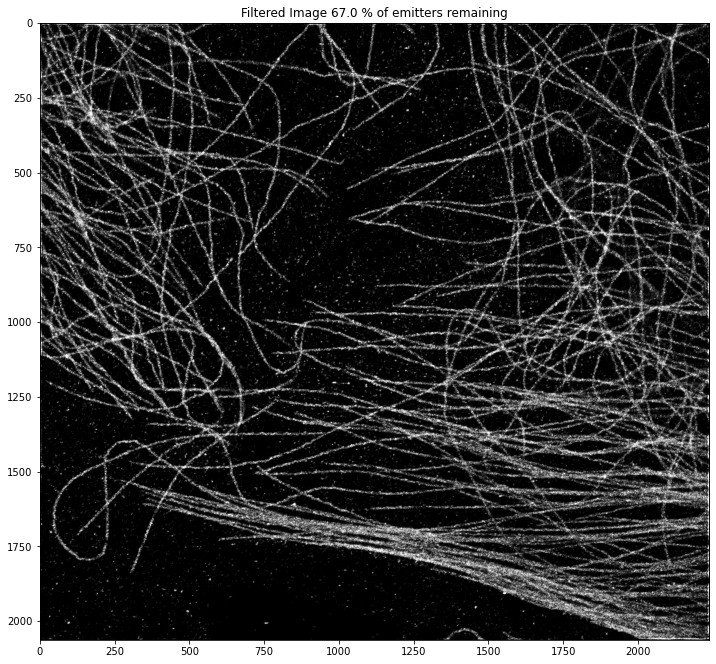

In [16]:
sigma_x_high_threshold = 40 
sigma_y_high_threshold = 40 
sigma_z_high_threshold = 80 

em_sub = emitter[(emitter.xyz_sig_nm[:, 0] <= sigma_x_high_threshold) * (emitter.xyz_sig_nm[:, 1] <= sigma_x_high_threshold) * (emitter.xyz_sig_nm[:, 2] <= sigma_z_high_threshold)]
# em_sub = emitter.filter_by_sigma(0.74)  # alternatively

plt.figure(figsize=(12, 12))
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., clip_percentile=97.).render(em_sub)
plt.title(f'Filtered Image {np.round(100*len(em_sub)/len(emitter))} % of emitters remaining')

plt.show()

Instead of specifying cutoffs for the three coordinates you can also use the filter_by_sigma method to directly specify what share of the emitters you wan't to keep.   
Below we remove the 60% of emitters with the highest weighted combined uncertainty.

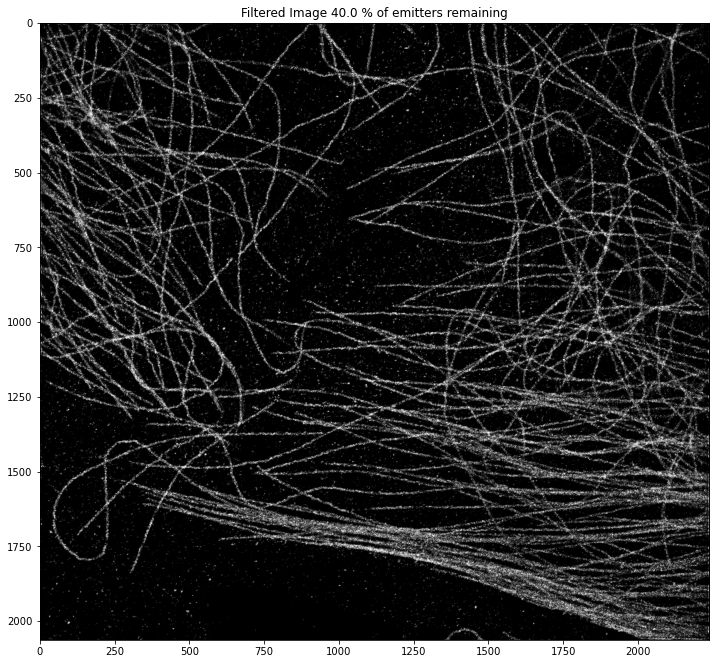

In [17]:
em_sub = emitter.filter_by_sigma(0.4)

plt.figure(figsize=(12, 12))
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., clip_percentile=97.).render(em_sub)
plt.title(f'Filtered Image {np.round(100*len(em_sub)/len(emitter))} % of emitters remaining')

plt.show()

## Save EmitterSet
There a different options to export your fitting results for later use. 

- The simplest one is saving it in CSV format which is compatible with most other frameworks. 
- Another option is saving via the native method `.save()` For this we use the backend of PyTorch, stored will be a dictionary of pytorch tensors as well as some meta information. 

In [ ]:
# csv export (loadable by most frameworks)
decode.utils.emitter_io.save_csv('emitter.csv', emitter.to_dict())

In [ ]:
# fast native save
emitter.save('emitter.pt')  # can be loaded via 'decode.EmitterSet.load('emitter.pt')'